In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [9]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

# Use ImageFolder for your dataset
trainset = datasets.ImageFolder(root='cropped/', transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root='cropped/', transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Get class names
classes = trainset.classes
print("Classes:", classes)


Classes: ['Machine', 'Philips', 'Plaster', 'Torx']


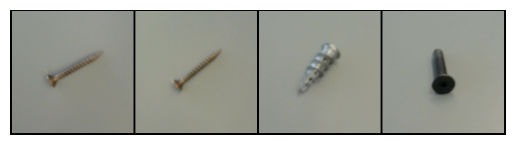

Philips Philips Plaster Machine


In [15]:
# Define unnormalize-and-show function
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize (because we normalized to [-1, 1])
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images from your custom dataset
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images as a grid
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(images))))

In [11]:
class Net(nn.Module):
    def __init__(self, num_classes=4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # 3 input channels (RGB), 32 output channels
        self.pool = nn.MaxPool2d(2, 2)  # Max pool with kernel size 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 32 input channels, 64 output channels
        
        # Calculate the output size after convolutions and pooling
        # After 2 convolutions and pooling layers with kernel size 2, the image size will be halved each time
        self._to_linear = None
        self._get_conv_output((3, 128, 128))  # (channels, height, width) of input images
        
        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 128)  # The size here is the flattened size after convolutions
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_output(self, shape):
        """ 
        Calculate the output size after convolutions and pooling
        For a given input shape.
        """
        x = torch.zeros(1, *shape)  # Simulate a dummy tensor with batch size 1
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first conv + pool
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second conv + pool
        self._to_linear = x.numel()  # Get the flattened size after convolutions
        return self._to_linear

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply conv1 + pool
        x = self.pool(torch.relu(self.conv2(x)))  # Apply conv2 + pool
        x = x.view(-1, self._to_linear)  # Flatten the output from conv2
        x = torch.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
net = Net(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(10):
    net.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(testloader):.4f}")

Epoch 1, Loss: 1.0725
Epoch 2, Loss: 0.2031
Epoch 3, Loss: 0.1692
Epoch 4, Loss: 0.1353
Epoch 5, Loss: 0.0469
Epoch 6, Loss: 0.0472
Epoch 7, Loss: 0.0650
Epoch 8, Loss: 0.1034
Epoch 9, Loss: 0.1069
Epoch 10, Loss: 0.0541


In [14]:
torch.save(net.state_dict(), 'TV_CNN.pth')